### Import libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

### Load data

In [4]:
data_dir = "../../database/machine_learning_data/"
sentiment_data_dir="../../database/sentiment_data/data-result/"

In [39]:
import os
def merge_data(ticker):
    merge_path = os.path.join(data_dir,ticker.zfill(4)+'.HK_macd-crossover.csv') 
    sentiment_path = os.path.join(sentiment_data_dir,'data-'+ticker.zfill(5)+'-result.csv') 

    merge_df =pd.read_csv(merge_path,index_col='Date',usecols=['Date','signal','GDP','Unemployment rate','Property price'],parse_dates=['Date'], na_values=['nan'])

    merge_df = merge_df.rename(columns={'signal': 'technical_signal'})
    sentiment_df =pd.read_csv(sentiment_path,index_col='dates',parse_dates=['dates'], na_values=['nan'])
    df=pd.merge(merge_df,sentiment_df, how='inner', left_index=True, right_index=True)
    return df
    
df=merge_data('5')

,technical_signal,GDP,Unemployment rate,Property price,vader_label,textblob_label
2017-01-03,0.0,0.837848,0.515625,0.743503,2.0,2.0
2017-01-04,0.0,0.837848,0.515625,0.743503,2.0,2.0
2017-01-05,0.0,0.837848,0.515625,0.743503,2.0,1.0
2017-01-06,0.0,0.837848,0.515625,0.743503,2.0,2.0
2017-01-09,0.0,0.837848,0.515625,0.743503,2.0,2.0


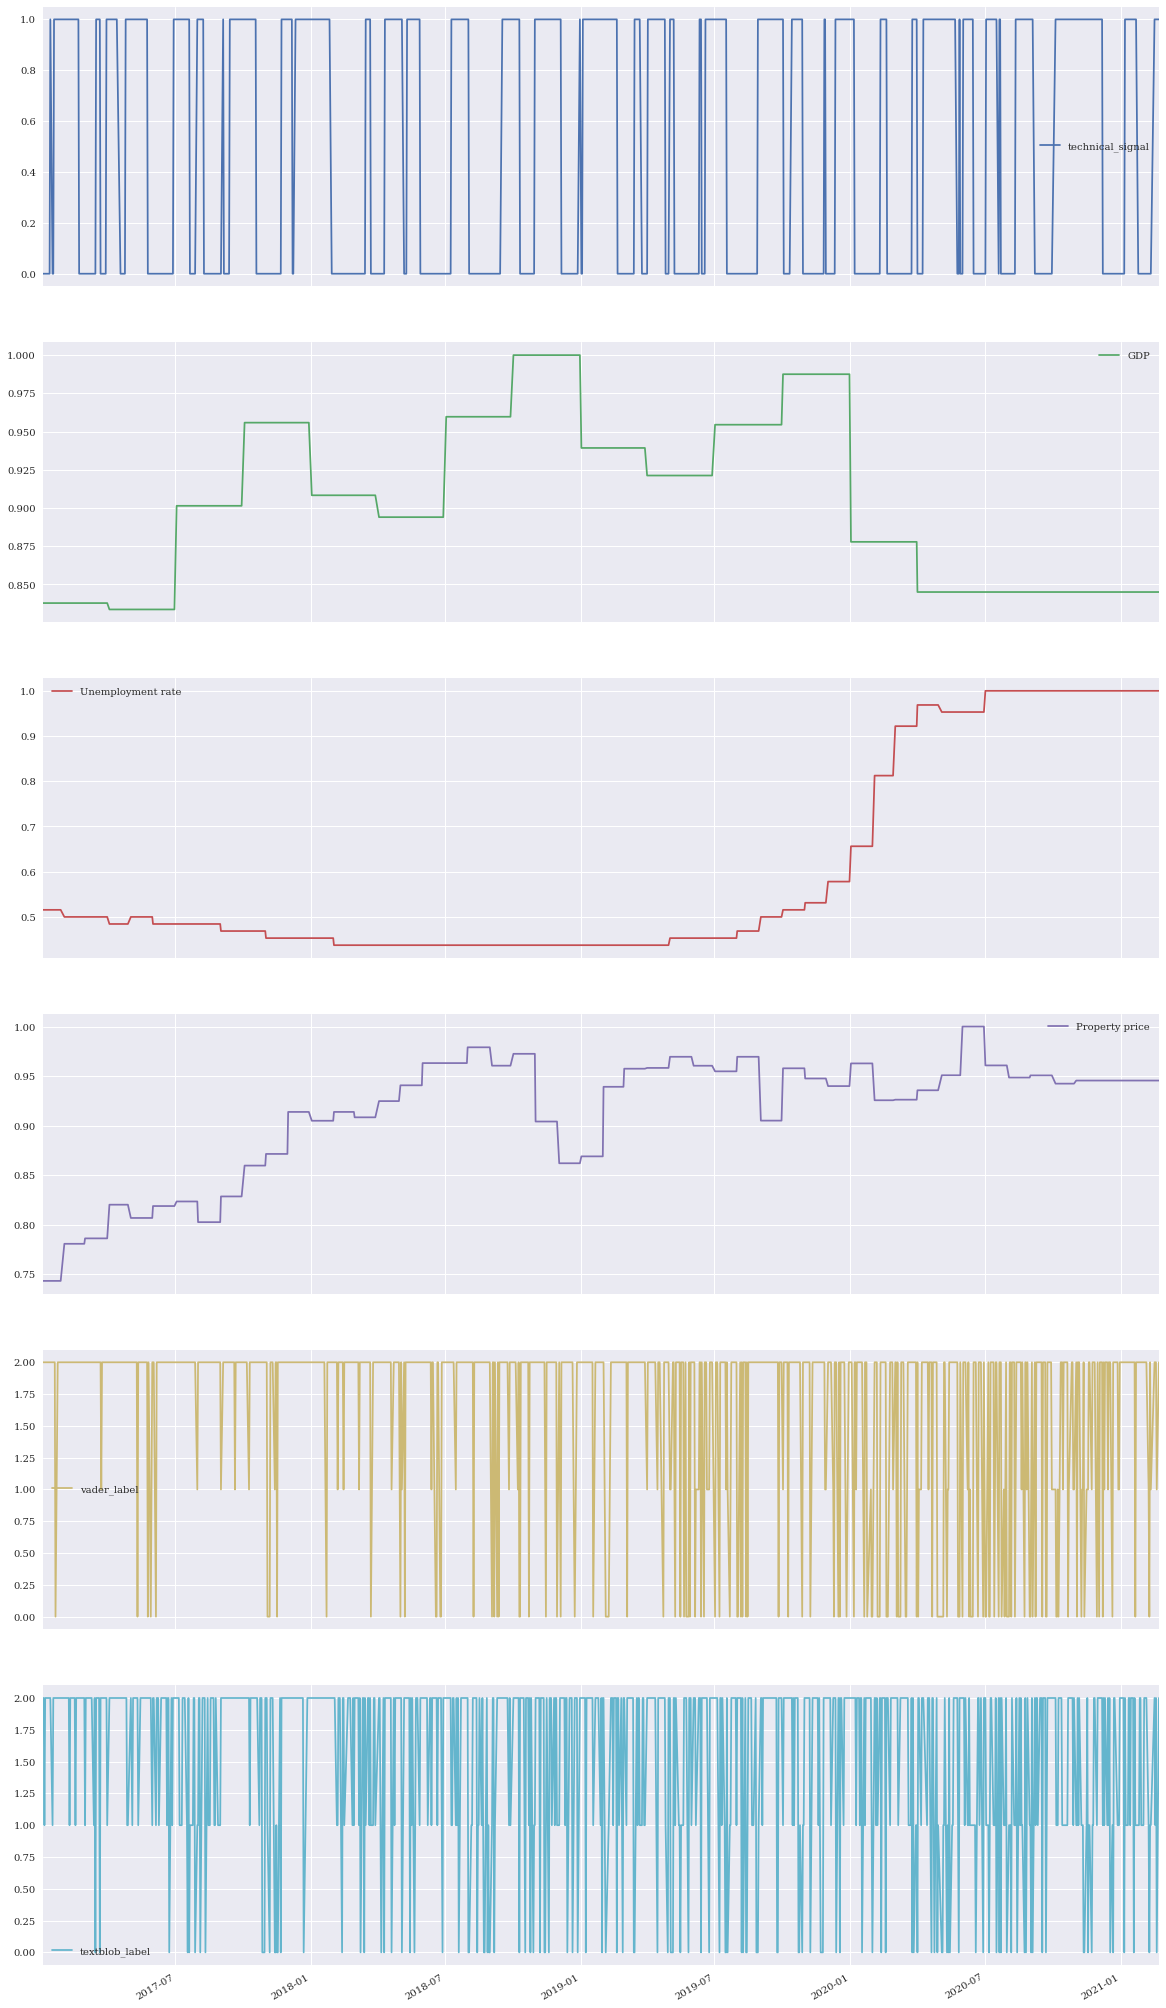

In [40]:

# print(df)
df.fillna(method='pad')
df.plot(figsize=(20, 40), subplots=True);
df.head()

In [41]:
df = df.fillna(method='ffill')
values=df.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled= scaler.fit_transform(values)
print(scaled)


[[-1.         -0.9498806  -0.7222222  -1.          1.          1.        ]
 [-1.         -0.9498806  -0.7222222  -1.          1.          1.        ]
 [-1.         -0.9498806  -0.7222222  -1.          1.          0.        ]
 ...
 [ 1.         -0.86304665  1.          0.57548094  1.          1.        ]
 [ 1.         -0.86304665  1.          0.57548094  0.         -1.        ]
 [ 1.         -0.86304665  1.          0.57548094  1.          1.        ]]


In [42]:
# function to create train, test data given stock data and sequence length
def load_data(data_raw, look_back):

    print(data_raw.shape)
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(values, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

(1037, 6)
x_train.shape =  (782, 59, 6)
y_train.shape =  (782, 6)
x_test.shape =  (195, 59, 6)
y_test.shape =  (195, 6)


In [43]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [44]:
y_train.size(),x_train.size()

(torch.Size([782, 6]), torch.Size([782, 59, 6]))

In [45]:
n_steps = look_back-1
batch_size = 32
num_epochs = 100 #n_iters / (len(train_X) / batch_size)

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### **Build model**

In [46]:
# Hyperparameters
input_dim = 6
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# check dimensions
print(model)

print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(6, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 6])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


### Train model

In [47]:
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.45036208629608154
Epoch  20 MSE:  0.4370776414871216
Epoch  30 MSE:  0.4289575219154358
Epoch  40 MSE:  0.42508840560913086
Epoch  50 MSE:  0.42239680886268616
Epoch  60 MSE:  0.41954201459884644
Epoch  70 MSE:  0.418277770280838
Epoch  80 MSE:  0.4175761640071869
Epoch  90 MSE:  0.41739505529403687


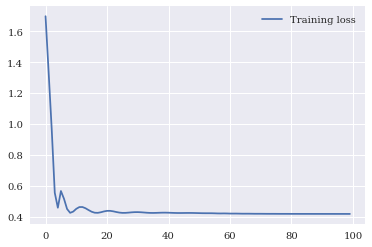

In [48]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [49]:
np.shape(y_train_pred)

torch.Size([782, 1])

In [59]:
# make predictions
y_test_pred = model(x_test)
print(np.shape(y_test_pred))

# reshape 
y_train_pred =y_train_pred.reshape(y_train_pred.shape[0],59)
y_train =y_train.reshape(y_train.shape[0],59)

y_test_pred =y_test_pred.reshape(y_test_pred.shape[0],59)
y_test =y_test.reshape(y_test.shape[0],59)


# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

torch.Size([195, 1])


RuntimeError: shape '[782, 59]' is invalid for input of size 782

(353, 1)


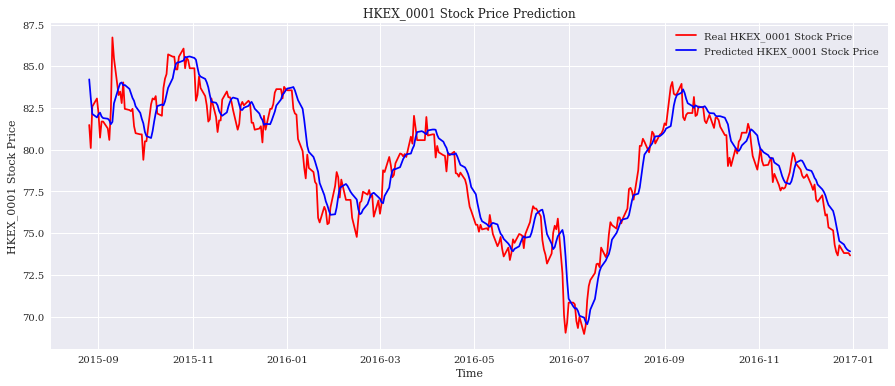

In [33]:
# Visualising the results
def visualization(df,y_test,y_test_pred):
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    print(y_test.shape)

    axes.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'Real HKEX_0001 Stock Price')
    axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted HKEX_0001 Stock Price')
    #axes.xticks(np.arange(0,394,50))
    plt.title('HKEX_0001 Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('HKEX_0001 Stock Price')
    plt.legend()
    #plt.savefig('HKEX_0001_pred.png')
    plt.show()

visualization(df_0001,y_test,y_test_pred)

In [34]:
#### References


- Predicting Stock Price using LSTM, *Taron Zakaryan* - https://www.kaggle.com/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch

               Close
2017-01-03  0.342003
2017-01-04  0.320400
2017-01-05  0.338680
2017-01-06  0.320400
2017-01-09  0.315416
...              ...
2020-09-24 -0.897675
2020-09-25 -0.890003
2020-09-28 -0.890003
2020-09-29 -0.891921
2020-09-30 -0.888085

[978 rows x 1 columns]
(978, 1)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

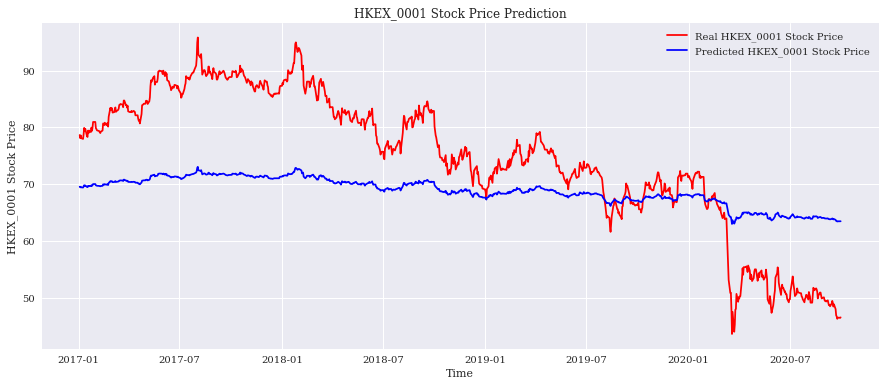

In [35]:
# function to generate signal for input data
from numpy import zeros, newaxis

def predict_data(stock):
    print(stock)

    actual_output = stock.values 
    
    actual_output = torch.from_numpy(actual_output).type(torch.Tensor)
    train_input=actual_output[:,:,newaxis]
    train_input=np.array(train_input)
    train_input= torch.from_numpy(train_input).type(torch.Tensor)

    # make prediction of the input 
    pred=model(train_input)

    # invert predictions
    pred = scaler.inverse_transform(pred.detach().numpy())
    actual_output = scaler.inverse_transform(actual_output.detach().numpy())
    print(pred.shape)
    return pred,actual_output

def generate_signal (pred,actual_output):
    signal=[]
    for p,a in zip(pred,actual_output):

        # shows that current price is overvalued, sell the stock
        if(p>a):
            signal.append(-1)
        # shows that current price is undervalued, buy the stock
        elif(p<a):
            signal.append(1)

        elif(p==a):
            signal.append(0)
    return signal


pred,acutal_output=predict_data(df_0001_test)
signal=generate_signal(pred,acutal_output)
print(signal)
visualization(df_0001_test,acutal_output,pred)




In [ ]:
import os
# data_dir = "../../database/sentiment_data/"
# def get_sentiment_results(df,test_dates):
    
#     # merge the time frame with the test_dates


#     # return the time frame

#     sentiment=[]
#     # vader label: 0=negative 1: neutral 2:positive
#     for i in len(df):
#         if(df['vader_label'].iloc[i]=='nan' and df['market_vader_label'].iloc[i]!='nan'):
#             sentiment.append(df['market_vader_label'].iloc[i])
#         elif (df['vader_label'].iloc[i]!='nan'):
#             sentiment.append(df['vader_label'].iloc[i])
#         else
#             sentiment.append('nan')
#     return  sentiment

# test_dates=pd.date_range('2017-01-03','2020-09-30',freq='B')
# name='00001'
# path=os.path.join(dirname,'data-results/'+'data-'+name+'-result.csv')
# df=pd.read_csv(path)
# sentiment=get_sentiment_results(df)
# print(sentiment)



# if signal==0 (neutral) 1==buy 2==sell
def adjust_signal(sentiment,signal):
    for i in len(signal):
        # if signal==1 and vader_label==2, signal =1
        if(signal[i]==1 and sentiment[i]==2):
            signal[i]=1
        # if signal==2 and vader_label=0, signal =2
        elif(signal[i]==2 and sentiment[i]==0):
            signal[i]=2
        # else signal=0
        else:
            signal[i]=0







    
            